In [35]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import scipy.linalg as LA
from scipy.signal import dlti, lsim, dlsim, butter, lfilter
import cvxpy as cp

In [2]:
## load excitation data
times = np.genfromtxt("../../data/ice_excitation/times.csv", delimiter=",")
speeds = np.genfromtxt("../../data/ice_excitation/speeds.csv", delimiter=",", usecols=(6,7,13,14,21))
meas_speeds = np.genfromtxt("../../data/ice_excitation/speed_measurements.csv", delimiter=",")
torques = np.genfromtxt("../../data/ice_excitation/torques.csv", delimiter=",", usecols=(8,18))
meas_torques = np.genfromtxt("../../data/ice_excitation/torque_measurements.csv", delimiter=",")

In [3]:
inertias = np.array([7.94e-4,
            3.79e-6,
            3.00e-6,
            2.00e-6,
            7.81e-3,
            2.00e-6,
            3.17e-6,
            5.01e-5,
            6.50e-6,
            5.65e-5,
            4.27e-6,
            3.25e-4,
            1.20e-4,
            1.15e-5,
            1.32e-4,
            4.27e-6,
            2.69e-4,
            1.80e-4,
            2.00e-5,
            2.00e-4,
            4.27e-6,
            4.95e-2])

stiffnesses = np.array([1.90e5,
               6.95e3,
               90.00,
               90.00,
               90.00,
               90.00,
               3*30.13, # the shaft with 6mm diameter has been replaced with an 8mm one
               4.19e4,
               5.40e3,
               4.19e4,
               1.22e3,
               4.33e4,
               3.10e4,
               1.14e3,
               3.10e4,
               1.22e4,
               4.43e4,
               1.38e5,
               2.00e4,
               1.38e5,
               1.22e4])

damping = np.array([8.08,
           0.29,
           0.24,
           0.24,
           0.24,
           0.24,
           0.00,
           1.78,
           0.23,
           1.78,
           0.52,
           1.84,
           1.32,
           0.05,
           1.32,
           0.52,
           1.88,
           5.86,
           0.85,
           5.86,
           0.52])


external_damping = np.array([0.0030,
                    0,
                    0,
                    0,
                    0,
                    0,
                    0,
                    0,
                    0,
                    0,
                    0,
                    0.0031,
                    0,
                    0,
                    0,
                    0,
                    0.0031,
                    0,
                    0,
                    0,
                    0,
                    0.2400])

gear_ratios = np.array([1,
               1,
               1,
               1,
               1,
               1,
               1,
               1,
               1,
               1,
               1,
               1/3,
               1,
               1,
               1,
               1,
               1/4,
               1,
               1,
               1,
               1])

In [4]:
def state_space_matrices(inertia, stiff, damp, damp_ext, ratios):
    cn = damp*ratios
    cn2 = damp*ratios**2
    cn2 = np.hstack((cn2, 0))
    c0 = np.copy(damp)
    c0 = np.insert(c0, 0, 0, axis=0)
    cn2d = -(c0 + cn2 + damp_ext)
    
    A11 = (np.diag(cn2d) + np.diag(cn, k=1) + np.diag(cn, k=-1)) / inertia.reshape(inertia.shape[0], 1)
    
    ks = -np.hstack((stiff, 0))
    A12 = np.delete((np.diag(ks) + np.diag(stiff, k=-1)) / inertia.reshape(inertia.shape[0], 1), -1, axis=1)
    
    
    A23 = np.delete(np.diag(np.hstack((ratios, 0))) + np.diag(-np.ones(len(ratios)), k=1), -1, axis=0)
    
    A = np.vstack((np.hstack((A11, A12)), np.hstack((A23, np.zeros((A23.shape[0], A23.shape[1]-1))))))
    
    B = np.zeros((A.shape[0], 2))
    B[0,0] += 1/inertia[0]
    B[len(inertia)-1, 1] -= 1/inertia[-1]
    
    C = np.zeros((3, A.shape[0]))
    C[0,6] += 1
    C[1,7] += 1
    C[2,30] += 5400
    D = np.zeros((C.shape[0], B.shape[1]))
    
    return A, B, C, D

In [5]:
def c2d(A, B, Ts):
    """
    C2D computes a discrete-time model of a system (A_c,B_c) with sample time T_s.
    The function returns matrices A,B of the discrete-time system.
    """
    m, n = A.shape
    nb = B.shape[1]

    s = np.concatenate([A,B], axis=1)
    s = np.concatenate([s, np.zeros((nb, n+nb))], axis=0)
    S = LA.expm(s*Ts)
    Ad = S[0:n,0:n]
    Bd = S[0:n,n:n+nb+1]
    
    return Ad, Bd

In [6]:
Fs = 1000 # Sampling frequency
sigma_m = 2/3 # worst case variance
mu_m = 2.7 # mean

## Sensor params
rpm_sensor_locations = [6, 7]
torque_sensor_locations = [8]
n_sensors = len(rpm_sensor_locations) + len(torque_sensor_locations)

## KALMAN FILTER DESIGN PARAMETERS
lag = 10
R = np.diag([0.05, 0.1, 0.2]) # measurement covariance R = E{v*v'}
Q = 0.01*np.eye(43) # diagonal matrix with shape of the A matrix

In [7]:
Ac, Bc, C, D = state_space_matrices(inertias, stiffnesses, damping, external_damping, gear_ratios)

In [8]:
A, B = c2d(Ac, Bc, 1/1000)

In [26]:
M = np.zeros((22, 22))
T = np.hstack([np.zeros((M.shape[0]-1, M.shape[0]-1)), np.zeros((M.shape[0]-1, 1)), np.diag(stiffnesses)]) # a matrix defining which states to be estimated
S = np.zeros((C.T).shape)
print(T.shape)

(21, 43)


In [27]:
def W(sigma_m):
    """
    Returns a filter for the extended system. The filter W is a transfer function
    of a quasi-stationary signal in state-space form.
    """
    var1, var2, a = 1, 0.1, 1 # design case 1
    # var1, var2, a = 1, (10/3)**2, 1 # design case 2

    r0 = (1 + a**2) * var2 + var1
    r1 = -a * var2
    c = r0/2/r1 + np.sqrt((r0/2/r1)**2 - 1)
    sigma_e = np.sqrt(r1/c)

    W_A = np.array(([0, 0, 0], [0, a, c*sigma_e], [0, 0, 0]))
    W_B = np.array(([sigma_m, 0], [0, sigma_e], [0, 1]))
    W_C = np.array(([1, 0, 0], [0, 1, 0]))
    W_D = np.zeros((2, 2))

    return W_A, W_B, W_C, W_D

In [28]:
W_A, W_B, W_C, W_D = W(sigma_m)

In [29]:
def extended_system(W_A, W_B, W_C, W_D, A, B, C, D, M, T, S, R, Q):
    """
    The extended state-space system used in the simultaneous input and state estimation.
    """
    nmasses = M.shape[0]
    Z1 = np.zeros((nmasses, nmasses-1))
    Z2 = np.zeros((nmasses-1, nmasses))
    Z3 = np.zeros((nmasses-1, nmasses-1))
    I = np.eye(nmasses)

    F = np.vstack([np.hstack([I, Z1]), np.hstack([Z2, Z3])])

    # the extended system
    Z_e = np.zeros((W_A.shape[0], A.shape[0]))

    A_e = np.vstack([np.hstack([W_A, Z_e]), np.hstack([(B @ W_C), A])])

    F_e = np.vstack([np.hstack([W_B, Z_e]), np.hstack([(B @ W_D), F])])

    C_e = np.hstack([np.zeros((C.shape[0], W_C.shape[1])), C])

    B_m = np.array(np.hstack([np.zeros((W_A.shape[0])), B[:,0]]))
    # convert B_m to nx1 array
    B_m = (np.zeros((1, B_m.shape[0])) + B_m).T

    T_e1 = np.hstack([W_C, np.zeros((2, A.shape[0]))])
    T_e2 = np.hstack([np.zeros((T.shape[0], W_A.shape[0])), T])
    T_e3 = np.hstack([np.zeros((nmasses, W_A.shape[0])), np.eye(nmasses), np.zeros((nmasses, nmasses-1))])
    print(T_e1.shape)
    print(T_e2.shape)
    print(T_e3.shape)
    T_e = np.vstack([T_e1, T_e2, T_e3])

    R_e = R

    Q_e1 = np.hstack([W_B @ W_B.T, W_B @ W_D.T @ B.T])
    Q_e21 = B @ W_D @ W_B.T
    Q_e22 = B @ W_D @ W_D.T @ B.T + F @ (F @ Q @ F.T) @ F.T
    Q_e2 = np.hstack([Q_e21, Q_e22])
    Q_e = np.vstack([Q_e1, Q_e2])

    S_e = np.vstack([np.eye(W_A.shape[0]), S])

    return A_e, F_e, C_e, B_m, T_e, R_e, Q_e, S_e # sys_extended


In [30]:
A_e, F_e, C_e, B_m, T_e, R_e, Q_e, S_e = extended_system(W_A, W_B, W_C, W_D, A, B, C, D, M, T, S, R, Q)

(2, 46)
(21, 46)
(22, 46)


In [31]:
def fixed_lag_smoothing(A_e, F_e, C_e, B_m, T_e, R_e, Q_e, S_e, lag):
    A_fls1 = np.hstack([A_e, np.zeros((A_e.shape[0], (lag-1)*T_e.shape[0]))])
    A_fls2 = np.hstack([T_e, np.zeros((T_e.shape[0], (lag-1)*T_e.shape[0]))])
    A_fls3 = np.hstack([
        np.zeros(((lag-2)*T_e.shape[0], A_e.shape[0])),
        np.eye((lag-2)*T_e.shape[0]),
        np.zeros(((lag-2)*T_e.shape[0], T_e.shape[0]))
    ])
    A_fls = np.vstack([A_fls1, A_fls2, A_fls3])

    F_fls = np.vstack([F_e, np.zeros(((lag-1)*T_e.shape[0], F_e.shape[1]))])

    C_fls = np.hstack([C_e, np.zeros((C_e.shape[0], (lag-1)*T_e.shape[0]))])

    B_m_fls = np.vstack([B_m, np.zeros(((lag-1)*T_e.shape[0], 1))])

    T_fls = np.hstack([
        np.zeros((T_e.shape[0], A_e.shape[0])),
        np.zeros((T_e.shape[0], (lag-2)*T_e.shape[0])),
        np.eye(T_e.shape[0])
    ])

    R_fls = R_e

    Q_fls = LA.block_diag(Q_e, 0*np.eye((lag-1)*T_e.shape[0]))

    S_fls = S_e

    return A_fls, F_fls, C_fls, B_m_fls, T_fls, R_fls, Q_fls, S_fls

In [32]:
A_fls, F_fls, C_fls, B_m_fls, T_fls, R_fls, Q_fls, S_fls = fixed_lag_smoothing(A_e, F_e, C_e, B_m, T_e, R_e, Q_e, S_e, lag)

In [33]:
def construct_kalman_filter(A, C, T, Q, R):
    P = LA.solve_discrete_are(A.T, C.T, Q, R) # ricatti_equation
    K = P @ C.T @ LA.inv(R + C @ P @ C.T)
    KC = K @ C
    Pz = T @ (np.eye((KC).shape[0]) - KC) @ P @ T.T

    KF_filter = dlti((np.eye(P.shape[0]) - K @ C) @ A, K, T, np.zeros((T.shape[0], C.shape[0])), dt=0.001)
    KF_pred = dlti(A - K @ C, K, T, np.zeros((T.shape[0], C.shape[0])), dt=0.001)

    return KF_filter, KF_pred, Pz, K

In [36]:
KF_filter, KF_pred, Pz, K = construct_kalman_filter(A_fls, C_fls, T_fls, Q_fls, R_fls)

In [37]:
## Estimation
y = np.vstack([meas_speeds, meas_torques])
u = mu_m*np.ones(y.shape[1])
Y = np.vstack([u, y])

In [54]:
KF2 = dlti(
    KF_filter.A,
    np.hstack([B_m_fls, KF_filter.B]),
    KF_filter.C,
    np.zeros((KF_filter.C.shape[0], KF_filter.B.shape[1]+1)),
    dt=0.001
)

print(C_fls.shape)
tout, yout, xout = dlsim(KF2, Y.T) # z_hat

angle_estimates = yout[:,2:22]
speed_estimates = yout[:,22+2:]

(3, 451)


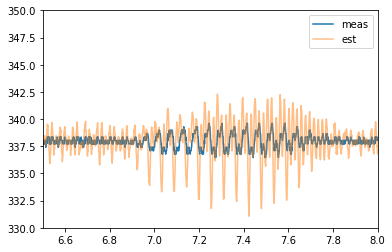

In [55]:
plt.plot(times, meas_speeds[0,:], label="meas")
plt.plot(times[:-lag], speed_estimates[lag:,rpm_sensor_locations[0]], label="est", alpha=0.5)
plt.xlim(6.5, 8)
plt.ylim(330, 350)
plt.legend()
plt.show()